# Humid Heat Metrics

## Overview

Humid heat metrics index temperature and humidity, which is often more useful than comparing either variable alone when considering perceived temperature, as they together affect the human body's ability to cool itself down. Humid heat metrics are especially important for the safety of outside workers, the elderly, or otherwise high-risk, high-exposure individuals. 

Wet Bulb Globe Temperature (WBGT) is a measure of heat stress. The equation for outdoor ($WBGT_{od}$) and indoor/shaded ($WBGT_{id}$) WBGTs are:

$WBGT_{od} = 0.7*T_{nwb} + 0.2*T_g + 0.1*T_a$

$WBGT_{id} = 0.7*T_{nwb} + 0.3*T_g$

where $T_a$ refers to Dry Bulb Ambient Temperatue, $T_{nwb}$ is the Natural Wet Bulb Temperature with exposure to wind and sun, and $T_g$ is the Globe Temperature taken from inside a copper globe painted black and exposed to the sun.

However, this formula is complicated by the reality that Natural Wet Bulb Temperature and Globe Temperature are not always readily available variables from weather stations or atmospheric models.

In this notebook, we will demonstrate the Australian Bureau of Meteorology (ABM) and Bernard methods of predicting wet bulb global temperature with a focus on the July 1995 Chicago heatwave.

For our analysis, we have ERA5 renanalysis data for the lower contiguous United States (50N, 24S, -66E, -125W) from July 1995 with the variables: 2-meter temperature, 2-meter dew point temperature, surface pressure, and *u*/*v* wind components.

Additional methods that may be considered and investigated in the future are: Hunter, Tonouchi, Liljegren, Li.

---

In [1]:
import geocat.datafiles as gdf
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from scipy import optimize

In [2]:
era5 = xr.open_dataset(gdf.get("netcdf_files/era5_1995-07-14T12.nc"))
era5.u10

<xarray.DataArray 'u10' (latitude: 105, longitude: 237)> Size: 100kB
[24885 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 948B -125.0 -124.8 -124.5 ... -66.25 -66.0
  * latitude   (latitude) float32 420B 50.0 49.75 49.5 49.25 ... 24.5 24.25 24.0
    time       datetime64[ns] 8B ...
Attributes:
    units:      m s**-1
    long_name:  10 metre U wind component

In [3]:
# Convert from Kelvin to Celsius

era5['t2m_C'] = era5['t2m'] - 273.15
era5['d2m_C'] = era5['d2m'] - 273.15

In [4]:
# Chicago coordinates
lat_chicago = 41.8781
lon_chicago = -87.6298

## Australian Bureau of Meteorology (ABM)

The [Australian Bureau of Meteorology](http://www.bom.gov.au/)'s method of estimating Wet Bulb Global Temperature is attractive due to its simplicity. It only requires temperature and water pressure (or relative humidity). 

Below is a chart of WBGT from relative humidity and temperature:
![](http://www.bom.gov.au/info/thermal_stress/wbgt_approximation.gif)

This method tends to overpredict WBGT compared to other models and assumes full sunlight and light breeze.

In [5]:
def calc_abm_wbgt(t_a, rh):
    p = (
        (rh / 100) * 6.105 * np.exp(17.27 * t_a / (237.7 + t_a))
    )  # water vapor pressure [hPa]
    wbgt = (0.567 * t_a) + (0.393 * p) + 3.94
    return wbgt

To use our ERA5 data in this equation, we need to first calculate relative humidiity (the ratio of vapor pressure to saturation pressure) from temperature and dewpoint. To do this we use the Magnus-Tetens Approxiimation for vapor pressures:

$$
e = 6.11 \exp {\left( \frac{17.625 \times t}{t + 243.04} \right)}
$$

where {e} is vapor pressure and {t} is temperature in Kelvin.

In [6]:
def _calc_vapor_pressure(t):  # Magnus-Tetens Approximation
    e = 6.11 * np.exp((17.625 * t) / (t + 243.04))  # Vapor Pressure in hPa
    return e


def calc_relative_humidity_era5(t_a, t_d):
    e = _calc_vapor_pressure(t_d)  # vapor pressure from dew point temp
    e_sat = _calc_vapor_pressure(t_a)  # saturation vapor pressure
    rh = 100 * e / e_sat  # Clausius-Clapeyron equation
    return rh


rh = calc_relative_humidity_era5(era5.t2m_C, era5.d2m_C)

In [7]:
wbgt_abm = calc_abm_wbgt(era5.t2m_C, rh)
wbgt_abm

<xarray.DataArray (latitude: 105, longitude: 237)> Size: 100kB
array([[17.870842, 16.18047 , 14.57531 , ..., 19.192104, 18.33654 ,
        18.172283],
       [18.569607, 17.136898, 17.365152, ..., 18.539204, 18.473352,
        18.543066],
       [17.96876 , 18.647879, 18.880539, ..., 18.72899 , 18.71052 ,
        18.844599],
       ...,
       [21.672411, 21.692675, 21.689726, ..., 30.19241 , 29.973494,
        29.821829],
       [21.93418 , 21.912344, 21.907938, ..., 30.340406, 30.14428 ,
        30.02978 ],
       [22.193027, 22.14459 , 22.129972, ..., 30.43058 , 30.351868,
        30.227827]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 948B -125.0 -124.8 -124.5 ... -66.25 -66.0
  * latitude   (latitude) float32 420B 50.0 49.75 49.5 49.25 ... 24.5 24.25 24.0
    time       datetime64[ns] 8B 1995-07-14T12:00:00

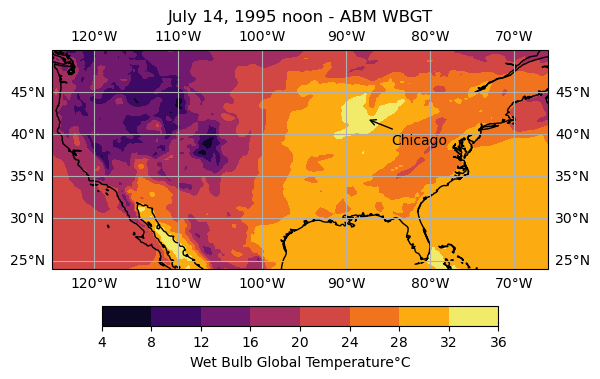

In [8]:
fig = plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())

c = plt.contourf(era5.longitude, era5.latitude, wbgt_abm, cmap='inferno')

ax.coastlines()
ax.gridlines(draw_labels=True)

cbar = plt.colorbar(c, ax=ax, orientation='horizontal', pad=0.1, shrink=0.8)
cbar.set_label('Wet Bulb Global Temperature' + '\N{DEGREE SIGN}' + 'C')

ax.set_title('July 14, 1995 noon - ABM WBGT')

ax.annotate(
    'Chicago',
    xy=(lon_chicago, lat_chicago),
    xytext=(lon_chicago + 3, lat_chicago - 3),
    arrowprops=dict(facecolor='black', arrowstyle='->'),
    transform=ccrs.PlateCarree(),
);

## Bernard

Bernard's semi-empirical formula approximates Natural Wet Bulb temperature based on heat exchange of a wetted wick exposed to sun and wind based on measurements of common United States summertime environmental conditions.

This is considered an indoor WBGT temperature because it does not include any strong radiative sources in the calculation.

$$
WBGT_{id} = \begin{cases} 
      0.7T_{pwb} + 0.3T_a & \text{if } v > 3 m/s\\
      0.67T_{pwb} + 0.33T_a − 0.048 log_10v (T_a − T_{pwb}) & \text{if } 0.3 \geq v \leq 3 m/s 
   \end{cases}
$$

In Bernard's analysis wind speeds less than 0.3 m/s are not included since the field of humid heat metrics is primarily concerned with workers and an outdoor worker is unlikely to be stationary. Apparent wind speeds are assumed to be at least 1 m/s.

This formula utilizes thermodynamic Wet Bulb Temperature ($T_{pwb}$), which is a wet bulb temperature in the shade and fanned or rotated. This is the wet bulb typically used for dew point calculations, and can be iteratively derived from temeperature ($T_a$) and dewpoint ($T_d$).

Read more about this method in [Bernard's 1999 'Prediction of Workplace Wet Bulb Global Temperature](https://www.tandfonline.com/doi/abs/10.1080/104732299303296).

In [9]:
# Bernard formula for WBGT
def calc_bernard_wbgt(t_a, t_pwb, v):
    if np.all(v < 0.3):  # m/s
        return np.nan  # Return NaN where velocity is below the threshold
    elif np.all((0.3 <= v) & (v <= 3)):
        wbgt = (0.67 * t_pwb) + (0.33 * t_a) - (0.48 * np.log10(v) * (t_a - t_pwb))
    else:
        wbgt = (0.7 * t_pwb) + (0.3 * t_a)

    return wbgt

According to [Lemke and Kjellstrom's 2011 'Calculating Workplace WBGT from Meteorological
Data: A Tool for Climate Change Assessment'](https://pubmed.ncbi.nlm.nih.gov/22673363/) $T_{pwb}$ is iteratively solved from McPherson's formula:

$$
1556 e_d - 1.484 e_d * T_{pwb} - 1556 e_w + 1.484 * e_w * T_{pwb} + 1010 * (t_a - t_pwb) = 0
$$

where $e_d = 6.106 * exp(17.27 * T_d / (237.3 + T_d))$ \
and $ e_w = 6.106 * exp(17.27 * T_{pwb} / (237.3 + T_{pwb}))$

Here we use a Newton-Raphson iterative method for the iterative solve for $t_{pwb}$. 

$$
x_{n+1} = x_n - \frac{f(x_n)}{f'(x_n)}
$$

Essentially, the Newton-Raphson is a root finding method that plugs you're initial guess into the equation in question and the derivative of that equation in order to get a more accurate guess. Repeat until your newguess is sufficiently precise. Thankfully we have [`scipy.optimize.newton()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.newton.html) to handle this solve for us.

In [10]:
# Scalar function to compute t_pwb
def _calc_tpwb_scalar(t_a, t_d):

    def f(t_pwb):
        e_d = 6.106 * np.exp(17.27 * t_d / (237.3 + t_d))  # hPa
        # e_w = 6.106 * np.exp(17.27 * t_pwb / (237.3 + t_pwb)) 
        func = (
            1556 * e_d
            - 1.484 * e_d * t_pwb
            - 1556 * (6.106 * np.exp(17.27 * t_pwb / (237.3 + t_pwb)))
            + 1.484 * (6.106 * np.exp(17.27 * t_pwb / (237.3 + t_pwb))) * t_pwb
            + 1010 * (t_a - t_pwb)
        )
        return func
    
    def f_prime(t_pwb, h=1e-5):  # numerical derivative
        return (f(t_pwb + h) - f(t_pwb - h)) / (2 * h)

    # Use the Newton-Raphson method with scipy's newton function
    t_pwb_0 = t_d  # initial guess
    t_pwb = optimize.newton(f, t_pwb_0, fprime=f_prime, tol=1e-6, maxiter=100)
    return t_pwb

# Apply function over grid
def _calc_tpwb(t_a, t_d):
    return xr.apply_ufunc(
        _calc_tpwb_scalar,
        t_a,
        t_d,
        vectorize=True,
        dask="parallelized",
        output_dtypes=[float],
    )

In [11]:
v = np.sqrt(era5.u10**2 + era5.v10**2)  # combine u and v wind components
t_pwb = _calc_tpwb(era5.t2m_C, era5.d2m_C)

wbgt_bernard = calc_bernard_wbgt(era5.t2m_C, t_pwb, v)
wbgt_bernard

<xarray.DataArray (latitude: 105, longitude: 237)> Size: 199kB
array([[13.695178  , 11.89261844, 10.13768247, ..., 14.99941441,
        14.13420708, 13.9702521 ],
       [14.41540541, 12.91479056, 13.15184303, ..., 14.35261484,
        14.28806844, 14.36000138],
       [13.78972268, 14.48720268, 14.72255427, ..., 14.55733826,
        14.54146855, 14.67784217],
       ...,
       [17.48846196, 17.50782951, 17.50468536, ..., 24.95087907,
        24.79825911, 24.69035188],
       [17.73965528, 17.71867846, 17.71419749, ..., 25.05317913,
        24.91488147, 24.82649699],
       [17.98647702, 17.94030654, 17.9263186 , ..., 25.11073911,
        25.0451701 , 24.94564864]])
Coordinates:
  * longitude  (longitude) float32 948B -125.0 -124.8 -124.5 ... -66.25 -66.0
  * latitude   (latitude) float32 420B 50.0 49.75 49.5 49.25 ... 24.5 24.25 24.0
    time       datetime64[ns] 8B 1995-07-14T12:00:00

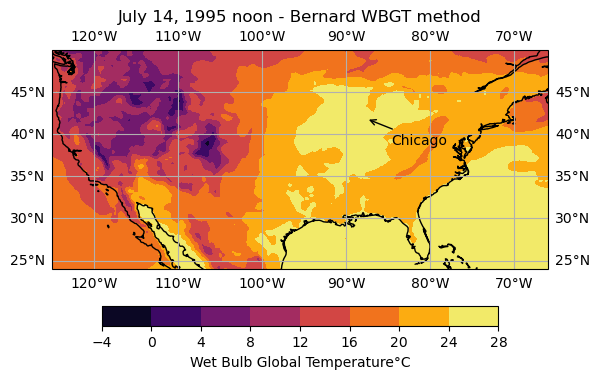

In [12]:
fig = plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())

c = plt.contourf(era5.longitude, era5.latitude, wbgt_bernard, cmap='inferno')

ax.coastlines()
ax.gridlines(draw_labels=True)

cbar = plt.colorbar(c, ax=ax, orientation='horizontal', pad=0.1, shrink=0.8)
cbar.set_label('Wet Bulb Global Temperature' + '\N{DEGREE SIGN}' + 'C')

ax.set_title('July 14, 1995 noon - Bernard WBGT method')

ax.annotate(
    'Chicago',
    xy=(lon_chicago, lat_chicago),
    xytext=(lon_chicago + 3, lat_chicago - 3),
    arrowprops=dict(facecolor='black', arrowstyle='->'),
    transform=ccrs.PlateCarree(),
);

## Comparing methods

The ABM model tends to overpredict WBGT compared to other models. When comparing our output from both ABM and Bernard, ABM is indeen higher by 4 - 7 degrees Celsius.

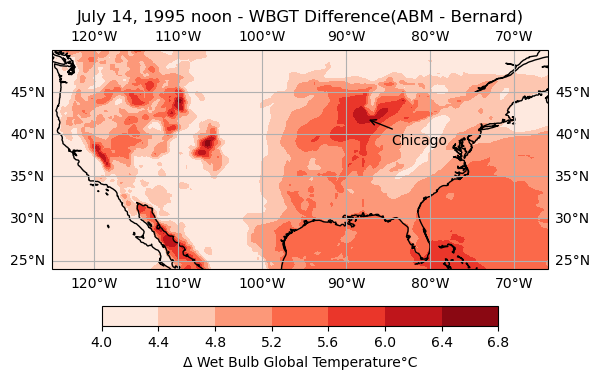

In [13]:
fig = plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())

diff = wbgt_abm - wbgt_bernard

c = plt.contourf(era5.longitude, era5.latitude, diff, cmap='Reds')

ax.coastlines()
ax.gridlines(draw_labels=True)

cbar = plt.colorbar(c, ax=ax, orientation='horizontal', pad=0.1, shrink=0.8)
cbar.set_label(
    '\N{GREEK CAPITAL LETTER DELTA} Wet Bulb Global Temperature'
    + '\N{DEGREE SIGN}'
    + 'C'
)
ax.set_title('July 14, 1995 noon - WBGT Difference(ABM - Bernard)')

ax.annotate(
    'Chicago',
    xy=(lon_chicago, lat_chicago),
    xytext=(lon_chicago + 3, lat_chicago - 3),
    arrowprops=dict(facecolor='black', arrowstyle='->'),
    transform=ccrs.PlateCarree(),
);

## References:

- Thomas E. Bernard (1999) Prediction of Workplace Wet Bulb Global Temperature, *Applied Occupational and Environmental Hygiene*, 14:2, 126-134, DOI:10.1080/104732299303296
- Lemke and Kjellstrom (2012) Calculating Workplace WBGT from Meteorological Data: A Tool for Climate Change Assessment, *Industrial Health* , 50, 267–278